In [1]:
import numpy as np
import calendar
import pandas as pd
import seaborn as sns
import pandas_ta as ta
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

#### Отличие временных рядов от обычных числовых данных

Временные ряды — это особый тип данных, который отличается от обычных числовых данных наличием временной компоненты. Это значит, что значения в временном ряду упорядочены по времени и зависимы от предыдущих значений.

1) Временная зависимость. Изменения в предыдущие моменты влияют на значения в текущий момент. 
2) Порядок значений. Перестановка значений исказит информацию.
3) Анализ временных рядов включает в себя изучение трендов, сезонности, автокорреляции и других временных закономерностей.

#### Основные концепции временных рядов

1. **Тенденция**: Тренд представляет собой общее направление, в котором временной ряд движется в течение длительного периода. Указывает, увеличиваются ли значения, уменьшаются или остаются относительно постоянными.
2. **Сезонность**: Сезонность относится к повторяющимся шаблонам или циклам, которые происходят с регулярными интервалами внутри временного ряда, часто соответствующим определенным единицам времени, таким как дни, недели, месяцы или сезоны.
3. **Скользящее среднее**: Метод скользящего среднего является распространенным приемом, используемым при анализе временных рядов для сглаживания краткосрочных колебаний и выделения долгосрочных тенденций или закономерностей в данных. Это включает в себя вычисление среднего значения набора последовательных точек данных, называемого “окном” или “скользящим окном”, по мере перемещения по временному ряду
4. **Шум**: Шум, или случайные флуктуации, представляет собой нерегулярные и непредсказуемые компоненты временных рядов, которые не следуют заметному шаблону. Он вводит изменчивость, которая не связана с основным трендом или сезонностью.
5. **Дифференцирование**: Дифференцирование используется для определения разницы в значениях указанного интервала. По умолчанию оно равно единице, мы можем указать разные значения для графиков. Это самый популярный метод удаления тенденций в данных.
6. **Стационарность**: Стационарный временной ряд - это такой, статистические свойства которого, такие как среднее значение, дисперсия и автокорреляция, остаются постоянными с течением времени.
7. **Порядок**: Порядок разнесения относится к тому, сколько раз данные временных рядов необходимо разнеси для достижения стационарности.
8. **Автокорреляция**: Автокорреляция - это статистический метод, используемый в анализе временных рядов для количественной оценки степени сходства между временным рядом и его версией с задержкой.
9. **Передискретизация**: Передискретизация - это метод анализа временных рядов, который включает изменение частоты наблюдений за данными. Он часто используется для преобразования данных с разной частотой (например, с ежедневной на ежемесячную), чтобы более четко выявить закономерности или тенденции.

In [66]:
def load_dataset_from_csv(path_to_file, method_of_processing_omissions='ffill'):
    """
    method_of_processing_omissions (str): Метод обработки пропусков. 
        Допустимые значения: 
        - "drop": удаляет строки с пропусками;
        - "fill": заполняет пробелы предыдущими значениями.
    """
    df = pd.read_csv(path_to_file, delimiter=',')

    if method_of_processing_omissions == 'drop':
        df = df.dropna()
    elif method_of_processing_omissions == 'ffill':
        df = df.fillna(method='ffill')
    else:
        raise ValueError(f"Incorrect pass processing method: {method_of_processing_omissions}")

    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    return df

start_df = pd.read_csv("XAUUSD_15M.csv", delimiter=',')
df = start_df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-07-05 00:00:00,2356.845,2357.555,2356.120,2357.125,858
2024-07-05 00:15:00,2357.215,2357.630,2356.720,2357.080,887
2024-07-05 00:30:00,2357.050,2358.930,2356.935,2358.380,1256
2024-07-05 00:45:00,2358.375,2359.125,2358.060,2358.935,1578
2024-07-05 01:00:00,2358.930,2360.400,2358.245,2359.685,2105
...,...,...,...,...,...
2024-07-22 03:30:00,2409.080,2409.575,2406.750,2406.990,1163
2024-07-22 03:45:00,2406.985,2407.310,2405.975,2406.805,579
2024-07-22 04:00:00,2406.880,2407.190,2404.695,2405.560,1008


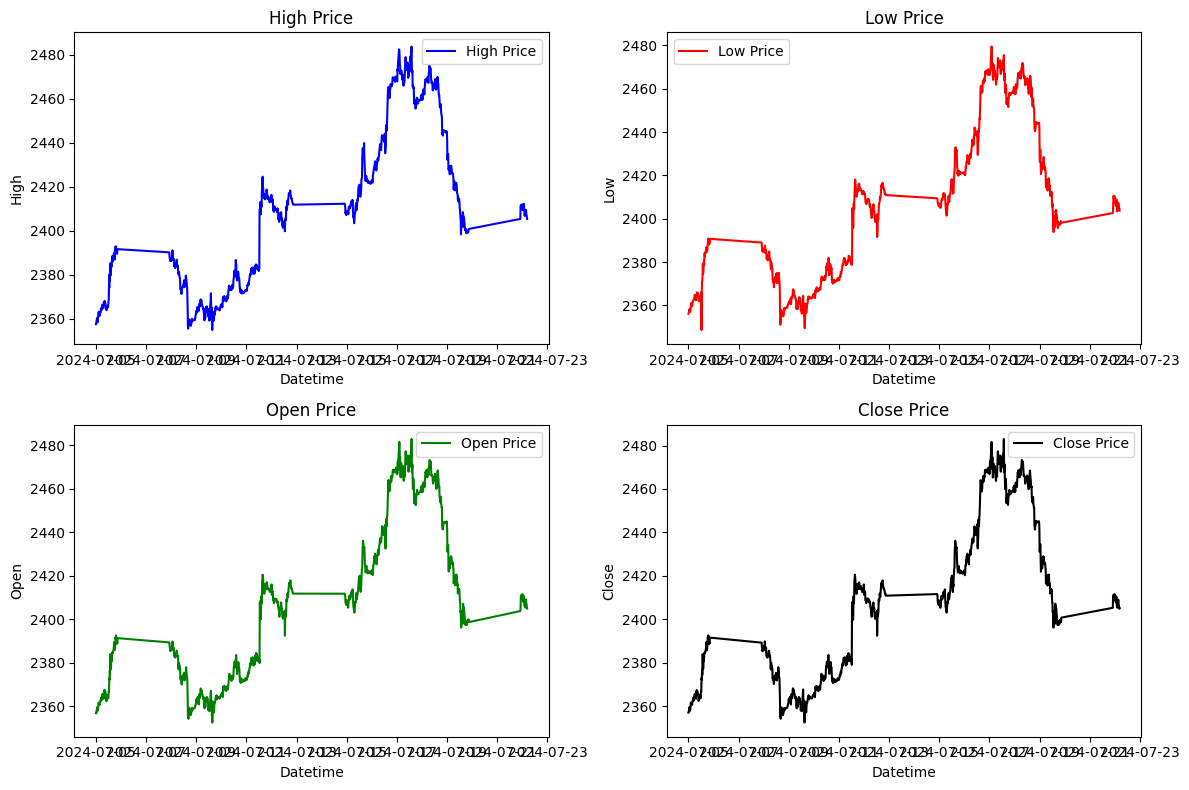

In [25]:
def show_price_charts(df):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # High Price
    sns.lineplot(data=df, x='Datetime', y='High', label='High Price', color='blue', ax=axes[0, 0])
    axes[0, 0].set_title('High Price')

    # Low Price
    sns.lineplot(data=df, x='Datetime', y='Low', label='Low Price', color='red', ax=axes[0, 1])
    axes[0, 1].set_title('Low Price')

    # Open Price
    sns.lineplot(data=df, x='Datetime', y='Open', label='Open Price', color='green', ax=axes[1, 0])
    axes[1, 0].set_title('Open Price')

    # Close Price
    sns.lineplot(data=df, x='Datetime', y='Close', label='Close Price', color='black', ax=axes[1, 1])
    axes[1, 1].set_title('Close Price')

    plt.tight_layout()
    plt.show()

show_price_charts(df)

#### Изменение шага временного ряда, сдвиг и скользящее среднее

In [27]:
df.resample(rule='30min').mean().head() # изменение шага

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-07-05 00:00:00,2357.0300,2357.5925,2356.4200,2357.1025,872.5
2024-07-05 00:30:00,2357.7125,2359.0275,2357.4975,2358.6575,1417.0
2024-07-05 01:00:00,2359.3025,2360.2950,2357.9250,2358.7675,2178.5
2024-07-05 01:30:00,2358.0525,2358.9225,2357.0950,2358.3750,1724.5
2024-07-05 02:00:00,2359.3500,2361.6350,2358.8625,2360.9600,1334.5


In [28]:
df.shift(2, axis = 0).head() # сдвиг

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-07-05 00:00:00,NaN,NaN,NaN,NaN,NaN
2024-07-05 00:15:00,NaN,NaN,NaN,NaN,NaN
2024-07-05 00:30:00,2356.845,2357.555,2356.120,2357.125,858.0
2024-07-05 00:45:00,2357.215,2357.630,2356.720,2357.080,887.0
2024-07-05 01:00:00,2357.050,2358.930,2356.935,2358.380,1256.0


In [29]:
df.rolling(window=3).mean().head() # скользящее среднее

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-07-05 00:00:00,NaN,NaN,NaN,NaN,NaN
2024-07-05 00:15:00,NaN,NaN,NaN,NaN,NaN
2024-07-05 00:30:00,2357.036667,2358.038333,2356.591667,2357.528333,1000.333333
2024-07-05 00:45:00,2357.546667,2358.561667,2357.238333,2358.131667,1240.333333
2024-07-05 01:00:00,2358.118333,2359.485000,2357.746667,2359.000000,1646.333333


In [13]:
def get_info_about_DataFrame(df):
    statistical_data = df.describe()
    statistical_data.loc['median'] = df.median()
    statistical_data.loc['var'] = df.var(numeric_only=True) # вычисление дисперсии

    print(df.info())
    print(statistical_data)

get_info_about_DataFrame(df)

<class 'pandas.core.frame.DataFrame'>
Index: 1389 entries, 7/1/2024 0:00 to 7/22/2024 4:30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1389 non-null   float64
 1   High    1389 non-null   float64
 2   Low     1389 non-null   float64
 3   Close   1389 non-null   float64
 4   Volume  1389 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 65.1+ KB
None
               Open         High          Low        Close        Volume
count   1389.000000  1389.000000  1389.000000  1389.000000  1.389000e+03
mean    2390.227284  2391.592084  2388.838503  2390.285299  2.123307e+03
std       43.835547    44.018625    43.622037    43.808842  1.531471e+03
min     2319.520000  2321.725000  2318.605000  2319.435000  9.700000e+01
25%     2358.580000  2359.635000  2357.630000  2358.555000  1.155000e+03
50%     2381.650000  2382.745000  2379.950000  2381.745000  1.840000e+03
75%     2418.570000  2420.855000  2416.820000  241

Асимметрия (Skewness) - измеряет асимметрию распределения данных. 
  * Положительная асимметрия: Пик распределения смещен влево, а хвост тянется вправо. 
  * Отрицательная асимметрия: Пик распределения смещен вправо, а хвост тянется влево.
  * Симметричное распределение: Пик распределения находится в центре, хвосты одинаковой длины.

Эксцесс (Kurtosis) - измеряет "остроту" пика распределения.
  * Лептокуртическое распределение: График имеет более высокий, узкий пик и более длинные хвосты.
  * Платикуртическое распределение: График имеет более широкий, плоский пик и более короткие хвосты.
  * Мезокуртическое распределение: График напоминает нормальное распределение.

Column: Open
Skewness: 0.36965335530487725
Kurtosis: -1.0627122058301601


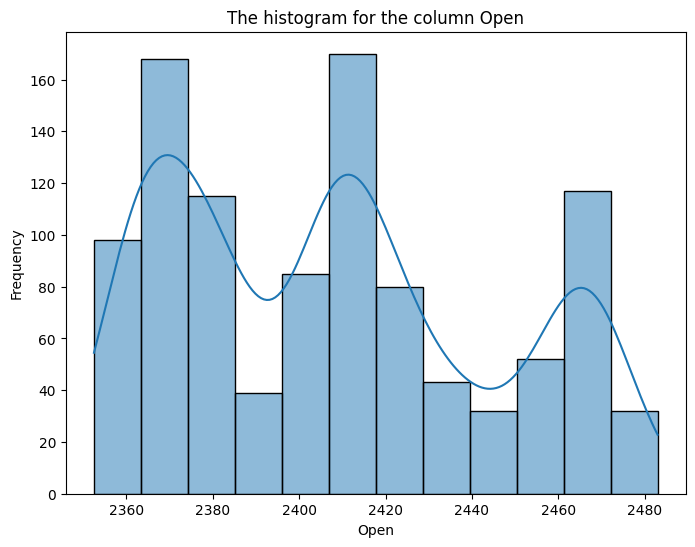

Column: High
Skewness: 0.3691529336561685
Kurtosis: -1.0601260163617459


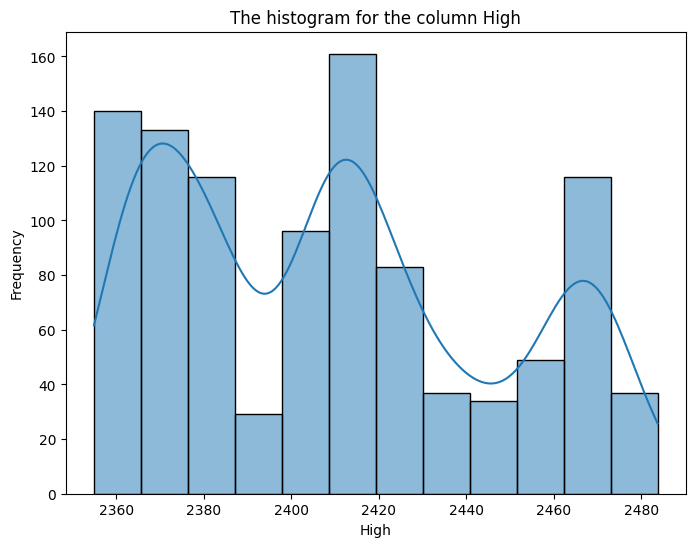

Column: Low
Skewness: 0.36941933391141013
Kurtosis: -1.0634103920137887


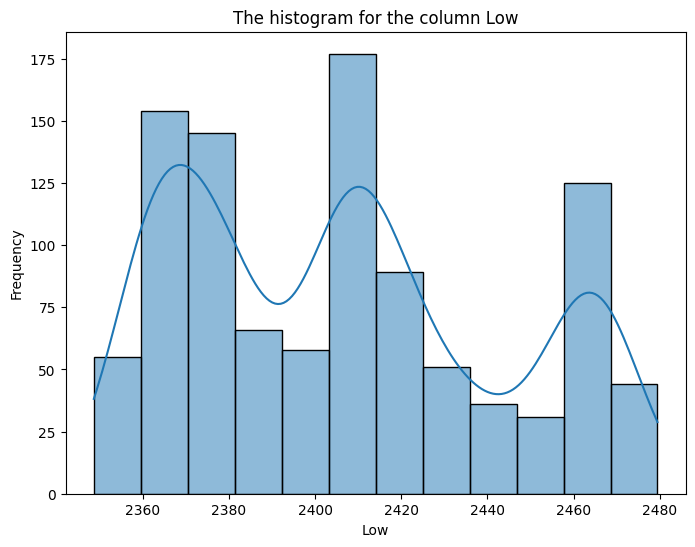

Column: Close
Skewness: 0.3696932576545305
Kurtosis: -1.0610260087514127


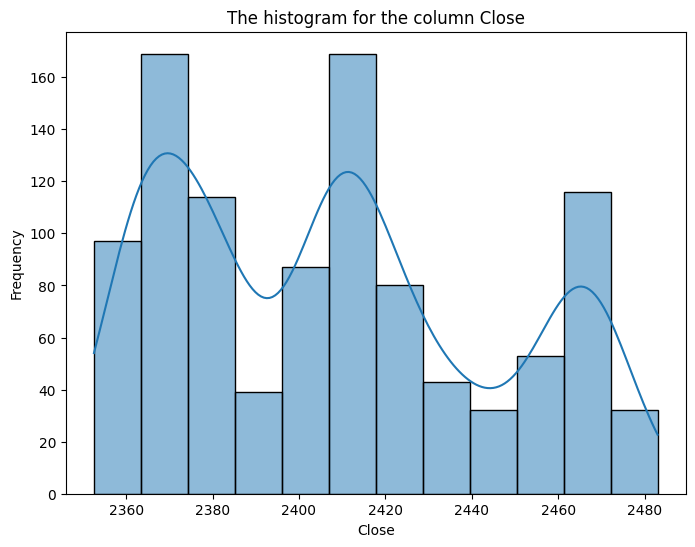

Column: Volume
Skewness: 1.7966468844406334
Kurtosis: 4.858171544711461


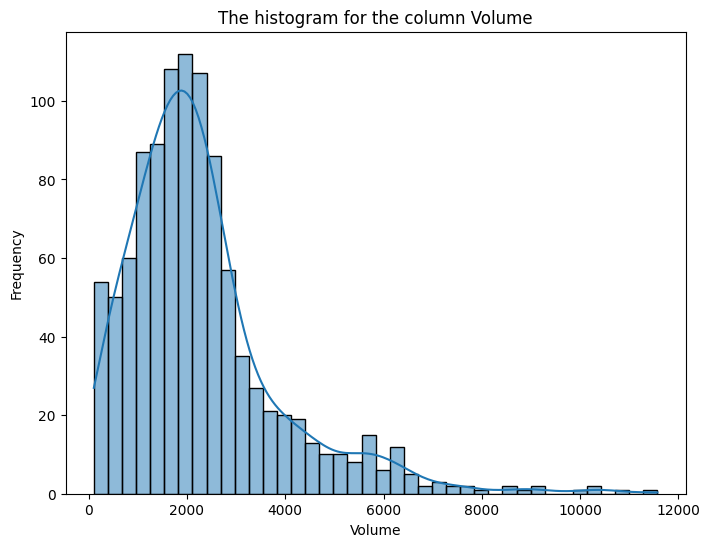

In [30]:
def analyze_skewness_and_kurtosis(df):
    for column in df.select_dtypes(include=np.number):
        skewness = df[column].skew()
        kurtosis = df[column].kurtosis()

        print(f"Column: {column}")
        print(f"Skewness: {skewness}")
        print(f"Kurtosis: {kurtosis}")

        plt.figure(figsize=(8, 6))
        sns.histplot(df[column], kde=True)
        plt.title(f"The histogram for the column {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

analyze_skewness_and_kurtosis(df)

In [41]:
# Количественно выбросы можно найти через стандартизированную оценку (z-оценку, z-score). 
# Эта оценка показывает на сколько средних квадратических отклонений значение отличается от среднего.
def detect_outliers_zscore(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    z_scores = (df[column] - mean) / std
    outliers = df[np.abs(z_scores) > threshold]
    return outliers

detect_outliers_zscore(df, "High", threshold=2)

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-07-17 02:00:00,2479.555,2482.420,2479.460,2481.625,2527
2024-07-17 13:45:00,2477.025,2483.505,2475.480,2482.995,6443
2024-07-17 14:00:00,2482.950,2483.740,2464.095,2467.665,8684


In [47]:
detect_outliers_zscore(df, "High", threshold=3) # обычно threshold устанавливают 3 (3 сигмы)

,Open,High,Low,Close,Volume
Datetime,,,,,


Outliers in the column 'Close':
                         Open      High      Low     Close  Volume
Datetime                                                          
2024-07-17 02:00:00  2479.555  2482.420  2479.46  2481.625    2527
2024-07-17 13:45:00  2477.025  2483.505  2475.48  2482.995    6443


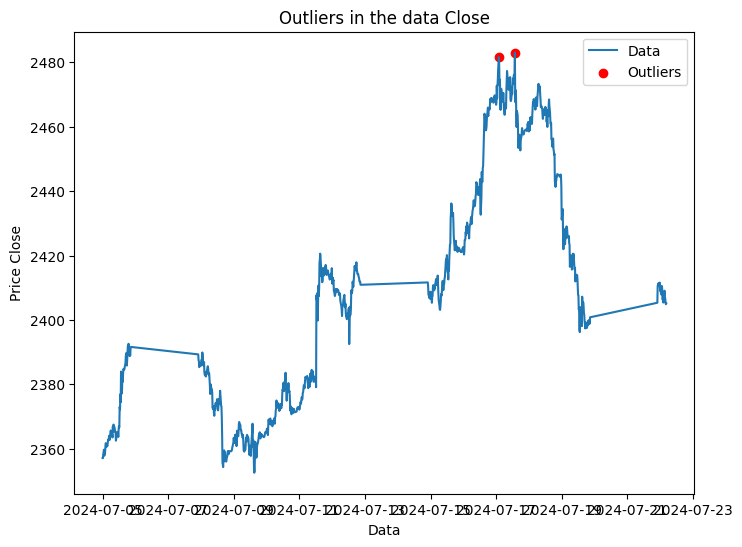

Outliers in the column 'High':
                         Open      High       Low     Close  Volume
Datetime                                                           
2024-07-17 02:00:00  2479.555  2482.420  2479.460  2481.625    2527
2024-07-17 13:45:00  2477.025  2483.505  2475.480  2482.995    6443
2024-07-17 14:00:00  2482.950  2483.740  2464.095  2467.665    8684


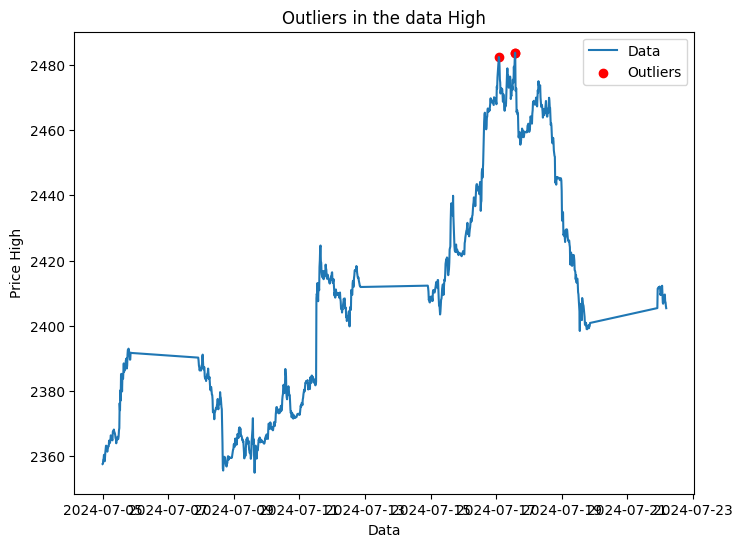

Outliers in the column 'Low':
                         Open     High      Low     Close  Volume
Datetime                                                         
2024-07-17 02:00:00  2479.555  2482.42  2479.46  2481.625    2527


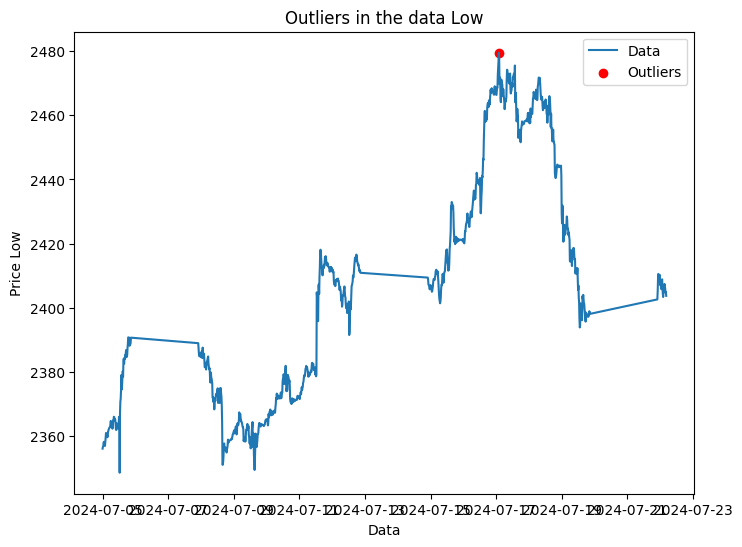

Outliers in the column 'Open':
                        Open      High       Low     Close  Volume
Datetime                                                          
2024-07-17 02:15:00  2481.62  2481.905  2477.790  2479.175    2068
2024-07-17 14:00:00  2482.95  2483.740  2464.095  2467.665    8684


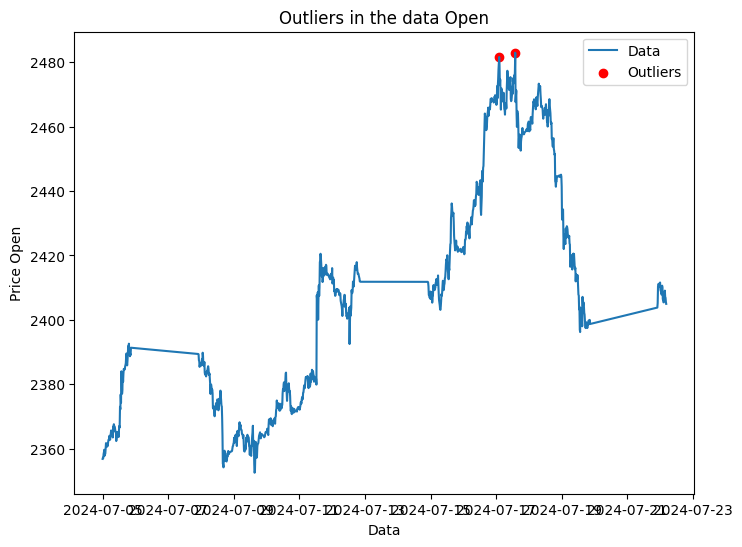

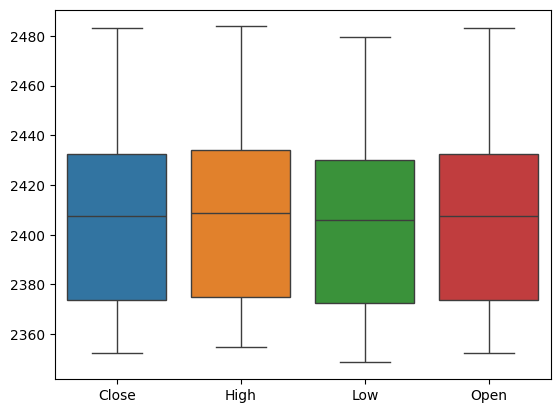

In [46]:
def get_outliers_zscore(df, columns_to_analyze=['Close', 'High', 'Low', 'Open']):
    for column in columns_to_analyze:
        outliers = detect_outliers_zscore(df, column, 2)
        print(f"Outliers in the column '{column}':\n{outliers}")

        plt.figure(figsize=(8, 6))
        plt.plot(df.index, df[column], label='Data')
        plt.scatter(outliers.index, outliers[column], color='red', label='Outliers')
        plt.title(f'Outliers in the data {column}')
        plt.xlabel('Data')
        plt.ylabel(f'Price {column}')
        plt.legend()
        plt.show()

    sns.boxplot(df[columns_to_analyze])

get_outliers_zscore(df)

Если есть выбросы, которые нас неустраивают, то можно их убрать
```
filled_data = df.copy()
indices = pd.DataFrame(detect_outliers_zscore(df, column)).index

rolling_median = df[column].rolling(window=window, min_periods=1).median()
filled_data.loc[indices, column] = rolling_median[indices]
```

#### Разложение временного ряда на компоненты

Выявление компонентов временного ряда (time series decomposition) предполагает его разложение на тренд, сезонность и случайные колебания.

- Тренд — долгосрочное изменение уровня ряда
- Сезонность предполагает циклические изменения уровня ряда с постоянным периодом
- Случайные колебания — непрогнозируемое случайное изменение ряда

Close


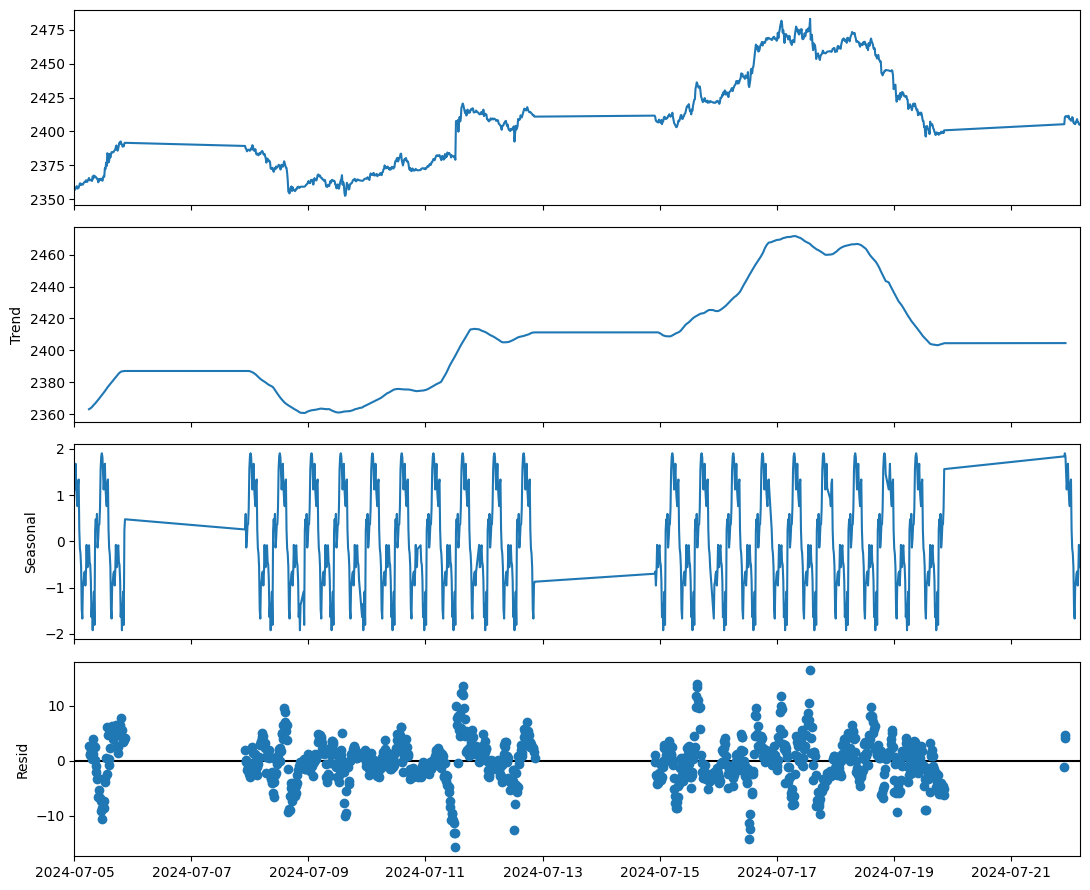

High


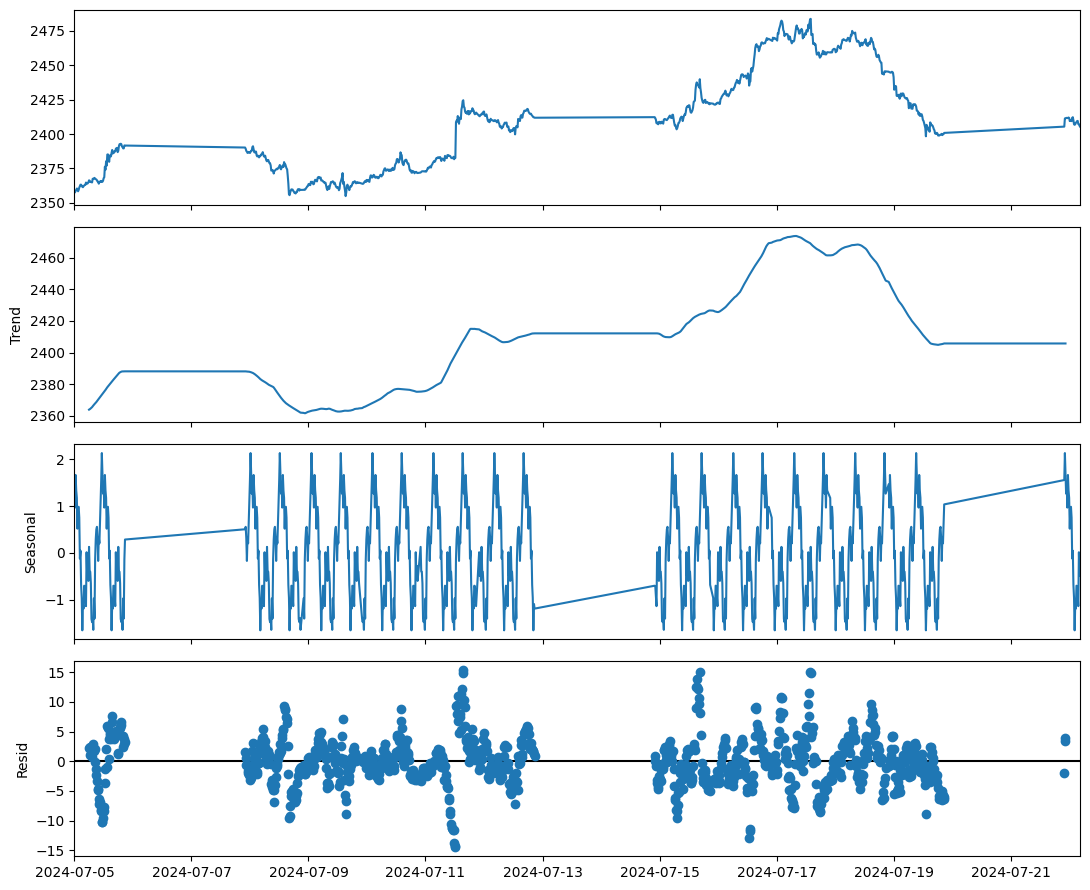

Low


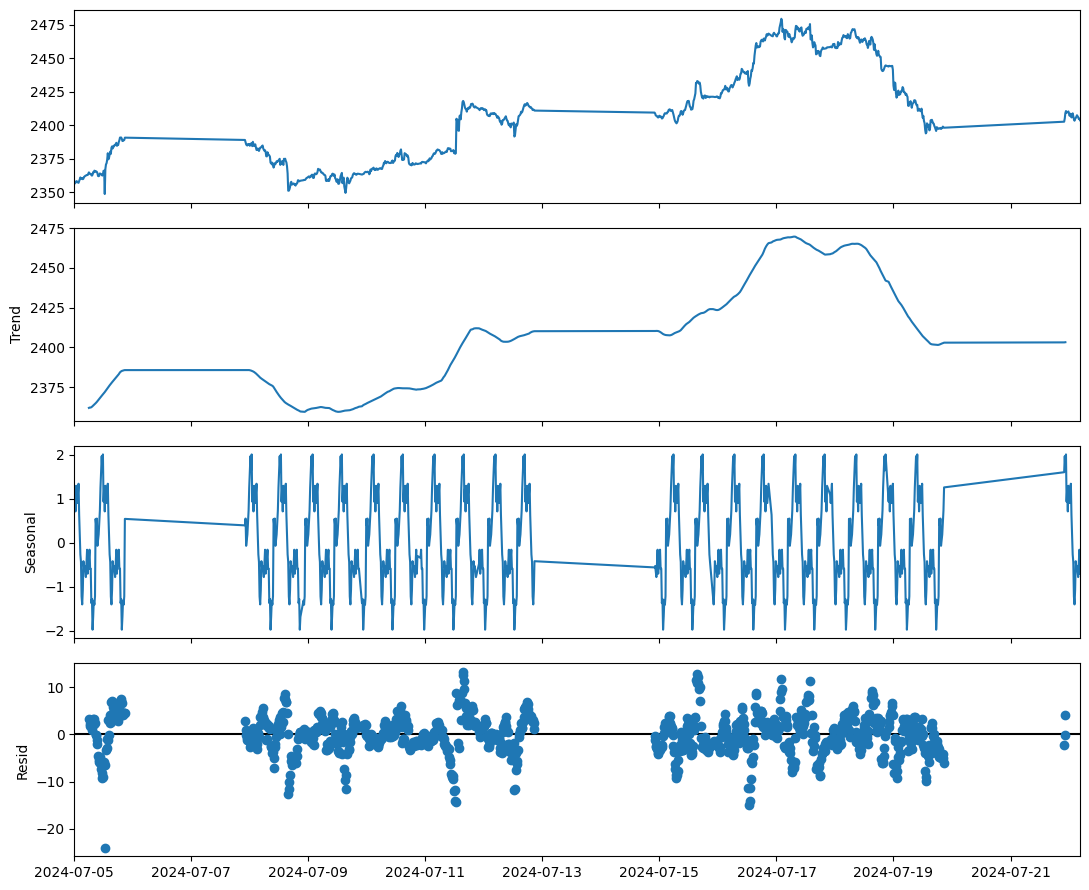

Open


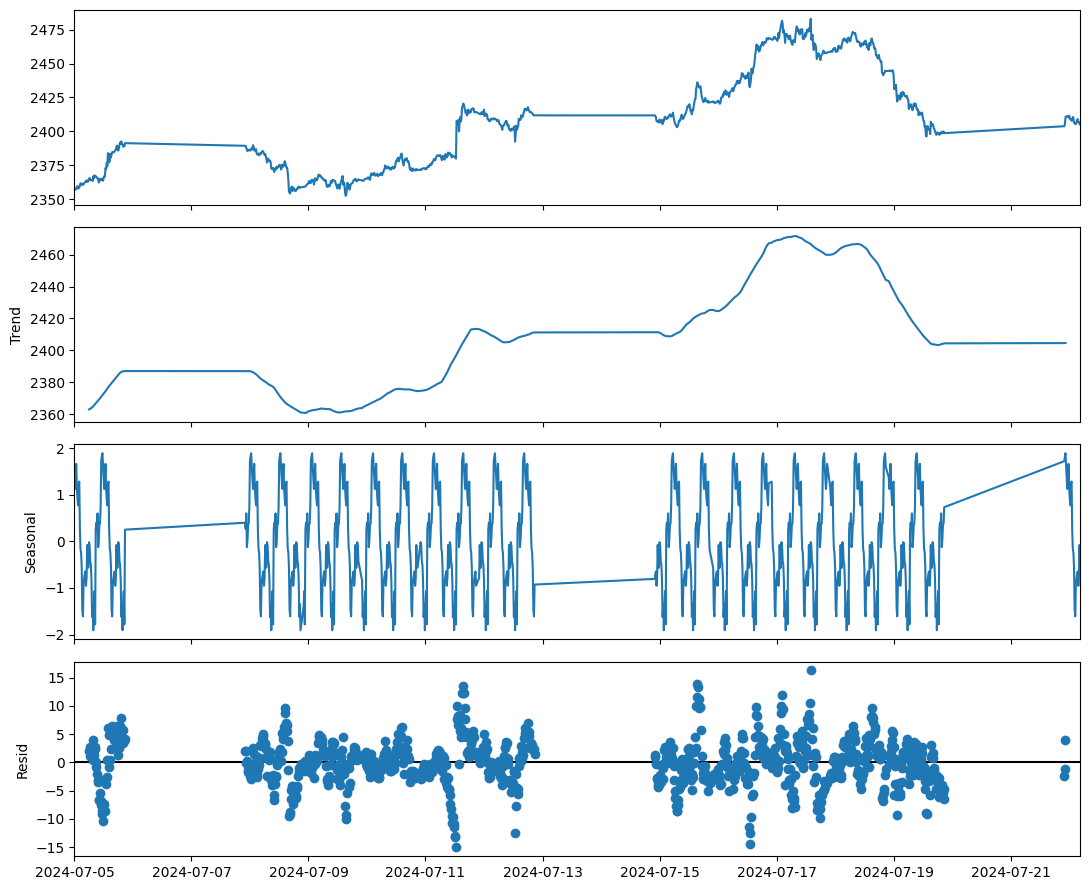

In [52]:
columns_to_analyze=['Close', 'High', 'Low', 'Open']
copy_df = df[columns_to_analyze]

for column in columns_to_analyze:
    print(column)
    rcParams['figure.figsize'] = 11, 9

    decompose = seasonal_decompose(copy_df[[column]], period=48)
    decompose.plot()

    plt.show()

Стационарность (stationarity) временного ряда как раз означает, что такие компоненты как тренд и сезонность отсутствуют. Говоря более точно, среднее значение и дисперсия не меняются со смещением во времени. Стационарность процесса можно оценить визуально.

Для более точной оценки стационарности можно применить тест Дики-Фуллера (Dickey-Fuller test).

#### Автокорреляция
Автокорреляция также показывает степень взаимосвязи в диапазоне от –1 до 1, но только не двух переменных, а одной и той же переменной в разные моменты времени.

Автокорреляционная функция (ACF) показывает, насколько сильно значения временного ряда коррелируют с прошлыми значениями того же ряда.
* Чтение графика:
    * Горизонтальная ось: Представляет лаги (количество временных интервалов между текущим значением и прошлым значением).
    * Вертикальная ось: Представляет значение автокорреляции.
    * Линии: Линии показывают корреляцию между значением временного ряда в текущий момент и значением в предыдущий момент с определенным лагом.
    * Синий оттенок: Синий цвет показывает доверительный интервал, который помогает определить статистически значимую корреляцию.
* Интерпретация:
    * Значимая автокорреляция: Если линия выходит за пределы доверительного интервала (синий оттенок), это говорит о значимой автокорреляции.
    * Падение автокорреляции: По мере увеличения лага автокорреляция обычно уменьшается. 
    * Сезонность: Если на графике ACF наблюдаются повторяющиеся пики на определенных лагах, это может указывать на сезонность в данных.

Частичная автокорреляционная функция (PACF) показывает, насколько сильно значения временного ряда коррелируют с прошлыми значениями, учитывая влияние всех предыдущих лагов.

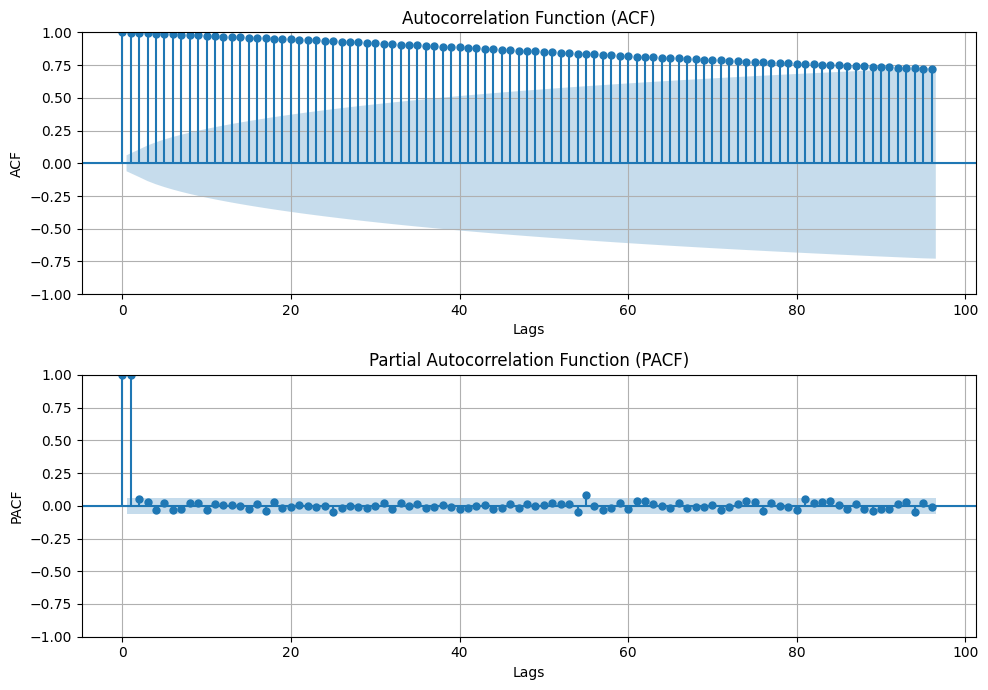

In [54]:
def plot_acf_pacf(data, lags=11680, figsize=(10, 7)):
    fig, axes = plt.subplots(2, 1, figsize=figsize)

    # Plot ACF
    plot_acf(data, lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')
    axes[0].set_xlabel('Lags')
    axes[0].set_ylabel('ACF')
    axes[0].grid(True)

    # Plot PACF
    plot_pacf(data, lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    axes[1].set_xlabel('Lags')
    axes[1].set_ylabel('PACF')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_acf_pacf(df["Close"], lags=96)

#### Немного о инженерии признаков

Инжиниринг признаков — это создание новых признаков на основе существующих признаков, и он добавляет в ваш набор данных информацию, которая в некотором роде полезна: добавляет признаки, полезные для вашего прогноза или задачи кластеризации, или упускает понимание взаимосвязей между признаками.

In [57]:
# Например, для прогнозирования временных рядов может быть удобнее работать не в самими ценами, а с дельтами цен 
# (изменение цены относительно предыдущей)
def calculate_deltas(df, columns_to_delta=None):
    if columns_to_delta is None:
        columns_to_delta = df.columns[:]
    else:
        columns_to_delta = [col for col in columns_to_delta if col in df.columns]
    
    df[columns_to_delta] = df[columns_to_delta].diff()
    
    df = df.dropna().reset_index(drop=True)

    return df

calculate_deltas(df)

,Open,High,Low,Close,Volume
0,-0.165,1.225,-0.385,1.345,340.0
1,1.325,-1.105,0.910,-0.745,-47.0
2,0.555,1.080,-0.940,0.195,205.0
3,0.745,-1.485,-0.825,-2.585,-380.0
4,-1.835,-1.570,0.260,2.265,-747.0
...,...,...,...,...,...
1024,1.280,-0.700,-1.670,-3.335,-73.0
1025,-2.095,-2.410,-0.110,1.910,175.0
1026,-0.105,2.145,-0.505,-1.060,1013.0
1027,-1.280,-1.000,1.455,0.570,-442.0


In [68]:
start_df['Datetime'] = pd.to_datetime(start_df['Datetime'])
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  1031 non-null   datetime64[ns]
 1   Open      1031 non-null   float64       
 2   High      1031 non-null   float64       
 3   Low       1031 non-null   float64       
 4   Close     1031 non-null   float64       
 5   Volume    1031 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 48.5 KB


In [69]:
# Также для предсказания цен для торговли на форекс важно учитывать дни недели, поэтому это может стать дополнительным признаком
def get_week_of_month(year, month, day):
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0] + 1
    return week_of_month

def extract_time_features(df):
    df['Hour'] = df['Datetime'].dt.hour
    df['DayOfWeek'] = df['Datetime'].dt.dayofweek  # 0 - monday, 6 - sunday
    df['WeekOfMonth'] = df.apply(lambda row: get_week_of_month(row['Datetime'].year, row['Datetime'].month, row['Datetime'].day), axis=1)
    df['Month'] = df['Datetime'].dt.month

    return df

extract_time_features(start_df)

,Datetime,Open,High,Low,Close,Volume,Hour,DayOfWeek,WeekOfMonth,Month
0,2024-07-05 00:00:00,2356.845,2357.555,2356.120,2357.125,858,0,4,1,7
1,2024-07-05 00:15:00,2357.215,2357.630,2356.720,2357.080,887,0,4,1,7
2,2024-07-05 00:30:00,2357.050,2358.930,2356.935,2358.380,1256,0,4,1,7
3,2024-07-05 00:45:00,2358.375,2359.125,2358.060,2358.935,1578,0,4,1,7
4,2024-07-05 01:00:00,2358.930,2360.400,2358.245,2359.685,2105,1,4,1,7
...,...,...,...,...,...,...,...,...,...,...
1026,2024-07-22 03:30:00,2409.080,2409.575,2406.750,2406.990,1163,3,0,4,7
1027,2024-07-22 03:45:00,2406.985,2407.310,2405.975,2406.805,579,3,0,4,7
1028,2024-07-22 04:00:00,2406.880,2407.190,2404.695,2405.560,1008,4,0,4,7
1029,2024-07-22 04:15:00,2405.600,2406.070,2404.870,2404.885,995,4,0,4,7


Так можно извлекать различную необходимую информацию. Если говорить о торговле не рынке Форекс, то ещё часто используют технические индикаторы. Например, 'SMA' (простая скользящая средняя ), 'EMA' (экспоненциальная скользящая средняя), 'RSI' (индекс относительной силы), 'ADX' (средний индекс направления), 'CCI' (индекс товарного канала) и многие другие